# Connecting our google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing the transformer module

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00


# Importing the required modules

In [ ]:
#importing the required modules

import numpy as np
import tensorflow as tf
import pandas as pd
import string
from tensorflow.keras.preprocessing.text import Tokenizer
import json
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from PIL import Image
import os
import time



# Code for the colab to take photo on demand

In [ ]:
#code for taking snaps

import cv2
import numpy as np
import base64
from IPython.display import display, Javascript
from google.colab.output import eval_js

def take_photo(filename='photo.jpg', quality=0.8):
    # Load the Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for a short delay to ensure the video stream stabilizes (you can adjust the delay if needed).
            await new Promise((resolve) => setTimeout(resolve, 200));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Convert the base64 image data to a numpy array
    img_data = data.split(',')[1]
    img_array = np.frombuffer(base64.b64decode(img_data), np.uint8)
    # Decode the numpy array to an OpenCV image
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Convert the image to grayscale if it has only one channel
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Grayscale img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)
    # Draw face bounding box on image
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Save image
    cv2.imwrite(filename, img)

    #return filename



# Vectorization and the creation of dataframe of the dataset for visualisation

<ipython-input-4-12ba9d6860a8>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(sampled_rows)
<ipython-input-4-12ba9d6860a8>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(sampled_rows)
<ipython-input-4-12ba9d6860a8>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(sampled_rows)
<ipython-input-4-12ba9d6860a8>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  undersampled_df = undersampled_df.append(sampled_rows)
<ipython-input-4-12ba9d6860a8>:12: FutureWarning: The frame.append method is deprecated and will be 

<Axes: >

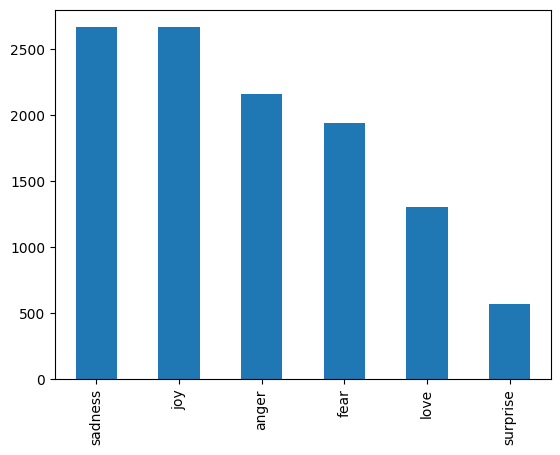

In [ ]:
#vectorization of text
df = pd.read_csv("/content/drive/MyDrive/final_version/nlp dataset/train_for_nlp.csv.csv")

target_frequency = df['Emotions'].value_counts().mean()

undersampled_df = pd.DataFrame(columns=['Emotions', 'Text'])

for emotion in df['Emotions'].unique():
    emotion_data = df[df['Emotions'] == emotion]
    num_samples = min(int(target_frequency), len(emotion_data))
    sampled_rows = emotion_data.sample(n=num_samples, random_state=42)
    undersampled_df = undersampled_df.append(sampled_rows)


result_df = undersampled_df.sample(frac=1, random_state=42)


xfeatures = result_df['Text']
ylables = result_df['Emotions']

#visualisaion

undersampled_df['Emotions'].value_counts().plot(kind = "bar")



# Vectorization

In [ ]:
cv = CountVectorizer()
x4 = cv.fit_transform(xfeatures)

In [ ]:
#loading the nlp models
nlp_model = joblib.load('/content/drive/MyDrive/final_version/nlp model /emotion_classifier_lr_model.pkl')


In [ ]:
#function to get the emotion from text
def predict_emotion(text , model):
  myvect = cv.transform(text).toarray()
  prediction = model.predict(myvect)
  #print(prediction,"\n")
  pred_prob = (model.predict_proba(myvect))
  #print(pred_prob,"\n")
  pred_percentage_for_all = dict(zip(model.classes_,pred_prob[0]))
  return prediction[0]

# Function for finding the max occuring of the list

In [ ]:


from collections import Counter

def max_occuring_element(lst):
    # Count the occurrences of each element in the list
    count_dict = Counter(lst)

    # Find the element with the maximum occurrence
    max_occurrence = max(count_dict.values())
    max_occuring_elements = [element for element, count in count_dict.items() if count == max_occurrence]

    return max_occuring_elements



# Loading our saved model for image emotion processing.

In [ ]:
#loading the emotional recognition model
emotion_model = load_model('/content/drive/MyDrive/final_version/emotion recogniton model/visualmodel_2.h5')

In [ ]:
tf.keras.utils.plot_model(emotion_model)

# Code for the decoading of emotion

In [ ]:
label_to_text = {0:'anger', 1: 'contempt',2:'disgust', 3:'fear', 4:'happy',5:'neutral', 6: 'sad', 7: 'surprise'}

# Preprocessing for the taken image from webcam

In [ ]:
#image pre processing
def pre_processing(filename):

    image = Image.open(filename)
    #image_grey = image.convert('L')
    # procesed_image = image.resize((224,224))
    # qq = np.array(procesed_image)
    #qq =np.expand_dims(qq,axis = -1)

    procesed_image = image.resize((224,224))
    qq = np.array(procesed_image)


    single_image_batch = np.expand_dims(qq, axis=0)
    z = emotion_model.predict(single_image_batch).argmax()

    return label_to_text[z]


In [ ]:
def emotion_image_detection(counter_var):
  file_name = "/content/drive/MyDrive/final_version/photo_detect/image{}.jpg".format(counter_var)
  take_photo(filename = file_name)
  value = pre_processing(file_name)
  return value






In [ ]:
#to get the promiment emotion out if the lit

from collections import Counter

def max_occuring_element(lst):
    # Count the occurrences of each element in the list
    count_dict = Counter(lst)

    # Find the element with the maximum occurrence
    max_occurrence = max(count_dict.values())
    max_occuring_elements = [element for element, count in count_dict.items() if count == max_occurrence]

    return max_occuring_elements


# The chat bot model

In [ ]:
import json
from difflib import get_close_matches

def load_knowlegde_base(path_file:str)-> dict:
  with open(path_file , 'r' ) as file:
    data: dict = json.load(file)
  return data

def save_knowledge_base(path_file : str , data :dict):
  with open(path_file , 'w') as file:
    json.dump(data , file , indent = 2)

def find_best_match(user_question: str , questions: list[str]) -> str|None:
  matches : list = get_close_matches(user_question ,  questions , n = 1 , cutoff
   = 0.6)
  return matches[0] if matches else None

def get_answer_for_question(question: str , knowledge_base : dict) -> str | None:
  for q in knowledge_base['question']:
    if q['question'] == question:
      return q['answer']




In [ ]:
import random
def chatbot():
  knowledge_base :dict = load_knowlegde_base('/content/drive/MyDrive/final_version/intent for chatbot/knowlede_base.json')


#exiting quotes
  exits = ["Goodbye for now, as I welcome the mysteries that the future holds",
         "In parting, I take with me the lessons learned and the strength gained.",
         "As I bid farewell, I carry the warmth of cherished moments in my heart.",
         "Like a shooting star, I leave a trail of dreams behind on my onward journey."]


  global emotion_list
  emotion_list = list()

  global emotion_list_visual
  emotion_list_visual = list()

  counter_variable = 0

  input_shape = 6
  image_file_list = []


  while True:
    user_input : str = input("YOU ->> ")
    emotion_list.append(predict_emotion([user_input],nlp_model))
    emotion_list_visual.append(emotion_image_detection(counter_variable))

    counter_variable = counter_variable + 1


    if user_input.lower() == 'goodbye':
      print("Sagittarias ->> :" ,exits[random.randint(0,3)])
      break
    best_match :str| None = find_best_match(user_input ,[ q['question'] for q in knowledge_base['question']])

    if best_match:
      answer : str = get_answer_for_question(best_match , knowledge_base)
      print(f'Sagittarias ->> : {answer}')

    else:
      print("Sagittarias : I do not know the answer .  Can you teach me ? ")
      new_answer: str = input(' ** Type the answer or skip ** ->')

      if new_answer.lower() != 'skip':
        knowledge_base['question'].append({"question" : user_input , "answer": new_answer})
        save_knowledge_base('/content/drive/MyDrive/final_version/intent for chatbot/knowlede_base.json' , knowledge_base)
        print('bot : Thank you learnt it')


In [ ]:
if __name__ == '__main__':
  chatbot()

YOU ->> hello


<IPython.core.display.Javascript object>

(480, 640)
1/1 [==============================] - 0s 379ms/step
Sagittarias ->> : What is up
YOU ->> nice 


<IPython.core.display.Javascript object>

(480, 640)
1/1 [==============================] - 0s 387ms/step
Sagittarias : I do not know the answer .  Can you teach me ? 
 ** Type the answer or skip ** ->do tell
bot : Thank you learnt it
YOU ->> nice


<IPython.core.display.Javascript object>

(480, 640)
1/1 [==============================] - 0s 230ms/step
Sagittarias ->> : do tell
YOU ->> i went to dakhineswer today


<IPython.core.display.Javascript object>

(480, 640)
1/1 [==============================] - 0s 222ms/step
Sagittarias ->> : wao thats great u must have learnt many new things
YOU ->> goodbye


<IPython.core.display.Javascript object>

(480, 640)
1/1 [==============================] - 0s 385ms/step
Sagittarias ->> : As I bid farewell, I carry the warmth of cherished moments in my heart.


In [ ]:
emotion_list

['joy', 'joy', 'joy', 'joy', 'joy']

In [ ]:
emotion_list_visual

['contempt', 'neutral', 'neutral', 'neutral', 'neutral']

In [ ]:
max_occuring_element(emotion_list)[0] and max_occuring_element(emotion_list_visual)[0]

'neutral'

In [ ]:
max_occuring_element(emotion_list_visual)[0] or  max_occuring_element(emotion_list)[0]

'neutral'

In [ ]:
print( max_occuring_element(emotion_list)[0]   )
print( max_occuring_element(emotion_list_visual)[0] )

if (max_occuring_element(emotion_list)[0] and max_occuring_element(emotion_list_visual)[0] ) in ['sad','sadness' , 'contempt' , 'anger' ,'disgust']:

  print(""" I'm sorry to that you're sad. Remember that you're not alone, \n
and it's okay to have these emotions. If you'd like, I'm here to listen and chat with you. \n
Sometimes, expressing your feelings can help lighten the load. \n
Just know that it's alright to reach out for support when you need it.""")

elif (  max_occuring_element(emotion_list_visual)[0] or  max_occuring_element(emotion_list)[0]   )  in [ 'happy' , 'surprise' , 'joy','neutral' ]:

  print("""Congratulations on being in such a great mood!\n
😄 Your positivity is truly contagious and it's wonderful to see your upbeat energy.\n
Keep spreading those good vibes and making the world a brighter place.\n
If there's anything you'd like to chat about or share, I'm here to listen and engage in some positive conversation! 🌞 """)

else:
  print(" Its nice talking to you good bye see you later ")


joy
neutral
Congratulations on being in such a great mood!

😄 Your positivity is truly contagious and it's wonderful to see your upbeat energy.

Keep spreading those good vibes and making the world a brighter place.

If there's anything you'd like to chat about or share, I'm here to listen and engage in some positive conversation! 🌞 


In [ ]:
# label_to_text = {0:'anger', 1: 'contempt',2:'disgust', 3:'fear', 4:'happy',5:'neutral', 6: 'sad', 7: 'surprise'}

#chatbot code
import random

#exiting quotes
exits = ["Goodbye for now, as I welcome the mysteries that the future holds",
         "In parting, I take with me the lessons learned and the strength gained.",
         "As I bid farewell, I carry the warmth of cherished moments in my heart.",
         "Like a shooting star, I leave a trail of dreams behind on my onward journey."]

emotion_list = []
emotion_list_visual = []

counter_variable = 0

input_shape = 6
image_file_list = []
#chatbot loop
while True:

  text_p = []
  prediction_input = input("you... :-->")
  emotion_list.append(predict_emotion([prediction_input],nlp_model))
  emotion_list_visual.append(emotion_image_detection(counter_variable))

  counter_variable = counter_variable + 1



  if prediction_input == "goodbye":
    print("Dell :" ,exits[random.randint(0,3)])
    break
  prediction_input = [letter.lower() for letter in prediction_input if letter not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  text_p.append(prediction_input)

  prediction_input = tokenizer.texts_to_sequences(text_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape )


  output = chatbot.predict(prediction_input)
  output = output.argmax()

  response_tag = le.inverse_transform([output])[0]

  print("Dell : ",random.choice(responses[response_tag]))


print(max_occuring_element(emotion_list))
print(max_occuring_element(emotion_list_visual))
if max_occuring_element(emotion_list) or max_occuring_element(emotion_list_visual) in ['sad' , 'contempt' , 'anger' ,'disgus']:
  print("i think you should listen to calmimg songs ")
else:
  print("here are some songs for you ")